<a href="https://colab.research.google.com/github/Shellyga/MAFAT-Radar-Challenge/blob/master/Copy_of_MAFAT_Radar_Challenge_Baseline_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MAFAT Radar Challenge - Baseline Model**

In this notebook, a Convolutional Neural Network (CNN) baseline model is presented. 

The model is trained on the training and auxiliary datasets.   
In the end, a submission file with predictions for the public test set is being created and downloaded.

The raw input for the model is the segments I/Q matrices.   
Note that this is a simplistic baseline model. The model should only be used as a boilerplate code to boost development and to accelerate participants' orientation phase. Participants are encouraged to explore different, more creative, approaches, such as data augmentation, unsupervised pre-training/autoencoders, RNNs/transformers, signal processing, feature engineering, transfer learning, etc.   
   
To learn more about signals, I/Q, Doppler and other terms please go to [Resources](https://competitions.codalab.org/competitions/25389#learn_the_details-resources) on the competition website.    
Please read the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing) to get familiar with the data.
   
Submissions are evaluated on the area under the Receiver Operating Characteristic Curve ([ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)).   
**The baseline model final result on the public test set is:   
 0.73 ROC AUC.**

[Competition website](https://competitions.codalab.org/competitions/25389)   
[MAFAT Challenge homepage](https://mafatchallenge.mod.gov.il/)

## **Setup**

In [2]:
!pip install tensorflow-determinism

  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-cp36-none-any.whl size=9156 sha256=2f25b9b2df1d0d80597e4f4fc6732bf93cb4adf0dd4081a941722bffe39a3a57
  Stored in directory: /root/.cache/pip/wheels/66/c3/18/13959a90d3e0d10182a99866d6ff4d0119e9daed6ce014b54c
Successfully built tensorflow-determinism


In [3]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.2.0'

In [4]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [5]:
# Set and test path to competition data files
# competition_path = 'INSERT HERE'
competition_path = '/My Drive/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**

All functions will be used in the "Training the Model" section.

### **Data loading**

In [6]:
# Functions for loading the data
def load_data(file_path):
  """
  Reads all data files (metadata and signal matrix data) as python dictionary,
  the pkl and csv files must have the same file name.

  Arguments:
    file_path -- {str} -- path to the iq_matrix file and metadata file

  Returns:
    Python dictionary
  """
  pkl = load_pkl_data(file_path)
  meta = load_csv_metadata(file_path)
  data_dictionary = {**meta, **pkl}
  
  for key in data_dictionary.keys():
    data_dictionary[key] = np.array(data_dictionary[key])

  return data_dictionary


def load_pkl_data(file_path):
  """
  Reads pickle file as a python dictionary (only Signal data).

  Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

  Returns:
    Python dictionary
  """
  # path = os.path.join(mount_path, competition_path, file_path + '.pkl')
  # print(mount_path)
  # print(path)
  part_path = '/content/gdrive/My Drive/Data/'
  path = os.path.join(part_path, file_path + '.pkl')
  with open(path, 'rb') as data:
    output = pickle.load(data)
  return output


def load_csv_metadata(file_path):
  """
  Reads csv as pandas DataFrame (only Metadata).

  Arguments:
    file_path -- {str} -- path to csv metadata file

  Returns:
    Pandas DataFarme
  """
  # path = os.path.join(mount_path, competition_path, file_path + '.csv')
  part_path = '/content/gdrive/My Drive/Data/'
  path = os.path.join(part_path, file_path + '.csv')
  with open(path, 'rb') as data:
    output = pd.read_csv(data)
  return output

## **Data Preprocessing**
**The preprocessing main steps:**   
1. Applying [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (Discrete Fourier transform) by using the fast Fourier transform algorithm ([FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) and [Hann function](https://www.mathworks.com/help/signal/ref/hann.html) to smooth the I/Q matrix. Afterward, calculating the absolute value of the I/Q matrix complex numbers.   
More information about Windowing and Hann function:   
[Wikipedia Hann](https://en.wikipedia.org/wiki/Hann_function#:~:text=The%20Hann%20function%20of%20length,can%20be%20even%20or%20odd.)   
[Wikipedia Window function](https://en.wikipedia.org/wiki/Window_function)   
2. Set max value on the center of the target's mass.   
The doppler burst is a vector (1 x 32) that marks the center of the target's mass on each I/Q matrix in every time unit (32 time-units).   
The preprocess sets the maximum value of each I/Q matrix in-place of the values at the center of the target's mass.
3. Normalization - Transforming I/Q matrix values to standardized values.   
Subtraction of the mean and division by the standard deviation.

**Preprocessing main steps explained:**   
The DFT converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa.   
The I/Q matrix in this challenge is being converted from the velocity domain to the frequency domain.
Windows (like "Hann") are used to reduce spectral leakage when performing a Fourier Transform on time data and converting it into the frequency domain.

The purpose of switching the values of the center of the target's mass in the I/Q matrix with the max value of the matrix is to enhance this part of the matrix and focus the model on this part.


Finally, the normalization is used for scaling all the I/Q matrices.

* *Note: the target_type lables are strings ("human" and "animal"), the data_preprocess function replaces them to "human" = 1 and "animal" = 0.*   
   


**The FFT Process Explained:**   
The IQ matrix contains 32 x 128 elements being 128 I/Q time data samples within a single radar processing time frame and 32 consecutive such time units. The X-axis represents the pulse transmission time, also known as “slow-time”. The Y-axis represents the reception time of signals with respect to pulse transmission time divided into 128 equal sized bins, also known as “fast-time”. The reason FFT is performed on the ‘fast time’ axis (i.e. 128 samples) rather than on the ‘slow time’ axis (i.e. 32 samples) is a matter of scale. An underlying assumption for an effective FFT analysis is that ‘acceleration’ during the time frame represented by the data is very low. Given the type of motion presented by humans and animals only the ‘fast time’ axis complies with this assumption.
Therefore, FFT processing should be applied over the dimension of 128 I/Q time samples to get the frequency content of the returned radar signal at each time frame. A spectrogram (as shown in the samples) is generated by attaching together 32 consecutive FFT results (please note that besides FFT processing some additional manipulation is required to properly display a spectrogram – like taking a LOG of the absolute value and passing a threshold – this is well detailed in the ‘Processing’ section of the competition notebook). Therefore, a spectrogram would eventually provide a display of how the frequency content of the returned signal is changing along time.

In [7]:
# Functions for preprocessing and preprocess function
def fft(iq, axis=0):
  """
  Computes the log of discrete Fourier Transform (DFT).
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform fft in (Default = 0)

  Returns:
    log of DFT on iq_burst array
  """
  iq = np.log(np.abs(np.fft.fft(hann(iq), axis=axis)))
  return iq


def hann(iq, window=None):
    """
    Preformes Hann smoothing of 'iq_sweep_burst'.

    Arguments:
      iq {ndarray} -- 'iq_sweep_burst' array
      window -{range} -- range of hann window indices (Default=None)
               if None the whole column is taken

    Returns:
      Regulazied iq in shape - (window[1] - window[0] - 2, iq.shape[1])
    """
    if window is None:
        window = [0, len(iq)]

    N = window[1] - window[0] - 1
    n = np.arange(window[0], window[1])
    n = n.reshape(len(n), 1)
    hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
    return (hannCol * iq[window[0]:window[1]])[1:-1]


def max_value_on_doppler(iq, doppler_burst):
  """
  Set max value on I/Q matrix using doppler burst vector. 
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
               
  Returns:
    I/Q matrix with the max value instead of the original values
    The doppler burst marks the matrix values to change by max value
  """
  iq_max_value = np.max(iq)
  for i in range(iq.shape[1]):
    if doppler_burst[i]>=len(iq):
       continue
    iq[doppler_burst[i], i] = iq_max_value
  return iq


def normalize(iq):
  """
  Calculates normalized values for iq_sweep_burst matrix:
  (vlaue-mean)/std.
  """
  m = iq.mean()
  s = iq.std()
  return (iq-m)/s


def data_preprocess(data):
  """
  Preforms data preprocessing.
  Change target_type lables from string to integer:
  'human'  --> 1
  'animal' --> 0

  Arguments:
    data -- {ndarray} -- the data set

  Returns:
    processed data (max values by doppler burst, DFT, normalization)
  """
  X=[]
  for i in range(len(data['iq_sweep_burst'])):
    iq = fft(data['iq_sweep_burst'][i])
    iq = max_value_on_doppler(iq,data['doppler_burst'][i])
    iq = normalize(iq)
    X.append(iq)

  data['iq_sweep_burst'] = np.array(X)
  if 'target_type' in data:
    data['target_type'][data['target_type'] == 'animal'] = 0
    data['target_type'][data['target_type'] == 'human'] = 1
  return data

### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

* Validation Set.   
The validation set is constructed from segments from geolocation_ids 1 and 4.   
These geolocations' target_type distributions are balanced.
To create a fair representation of the test set   
(one segment form each track) every sixth segment was taken to the validation set.   
The reason is that approximately 75% of the tracks have less than 6 segments (see the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing)),   
it guarantees that most of the segments in the validation set are not from the same track.   
   
* Adding "human" segments to the training set.   
The training set is imbalanced (more animals than humans, see the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing).   
One can address this issue by taking segements of humans from the "Auxiliary Experiment Set".   
The first 3 segments from each track are taken into the training set (or less if the track is shorter than 3 segments).

In [8]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset
def split_train_val(data):
  """
  Split the data to train and validation set.
  The validation set is built from training set segments of 
  geolocation_id 1 and 4. 
  Use the function only after the training set is complete and preprocessed. 

  Arguments:
    data -- {ndarray} -- the data set to split

  Returns:
    iq_sweep_burst ndarray matrices
    target_type vector 
    for training and validation sets
  """
  idx = ((data['geolocation_id'] == 4) | (data['geolocation_id'] == 1))\
   & (data['segment_id'] % 6 == 0)
  training_x = data['iq_sweep_burst'][np.logical_not(idx)]
  training_y = data['target_type'][np.logical_not(idx)]
  validation_x = data['iq_sweep_burst'][idx]
  validation_y = data['target_type'][idx]
  return training_x, training_y, validation_x, validation_y

def aux_split(data):
  """
  Selects segments from the auxilary set for training set.
  Takes the first 3 segments (or less) from each track.

  Arguments:
    data {dataframe} -- the auxilary data

  Returns:
    The auxilary data for the training
  """
  idx = np.bool_(np.zeros(len(data['track_id'])))
  for track in np.unique(data['track_id']):
    idx |= data['segment_id']==(data['segment_id'][data['track_id'] == track][:3])
  
  for key in data:
    data[key] = data[key][idx]
  return data

# Model VGG16 

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
def create_vgg_model(input_shape):
  model = VGG16(weights='imagenet',include_top=False,input_shape= input_shape)
  model = VGG16(include_top=False,input_shape= input_shape)
  return model

In [10]:
def extract_features(model,train_X,valid_X,batch_size):
    train_features = model.predict(np.array(train_X), batch_size, verbose=1)
    val_features = model.predict(np.array(valid_X), batch_size, verbose=1)
    # Current shape of features
    print(train_features.shape, "\n", val_features.shape)
    return train_features,val_features
    

In [11]:
def flatten_extracted_features(train_features,val_features):
    train_features_flat = np.reshape(train_features, (6568, 3*1*512))
    val_features_flat = np.reshape(val_features, (309, 3*1*512))
    return train_features_flat,val_features_flat

## **Model**

### **CNN Model**
The model has two convolutional layers, both followed by max-pooling layers.    
Those layers are followed by 2 fully-connected (dense) layers, activated with a ReLU function and regularized with   
L2 regularization, followed by a final output layer with a single neuron with a Sigmoid activation function,   
used for final binary classification.

In [37]:
# Building the model
def create_model(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  return model

### **Evaluation and Visualization of Model's results**

In [12]:
# Function for calculating the final ROC-AUC score and plot the ROC curve,
# used in the "Results" section
def stats(pred, actual):
  """
  Computes the model ROC-AUC score and plots the ROC curve.

  Arguments:
    pred -- {ndarray} -- model's probability predictions
    actual -- the true lables

  Returns:
    ROC curve graph and ROC-AUC score
  """
  plt.figure(figsize=(20, 10))
  fpr1, tpr1, _ = roc_curve(actual[0], pred[0])
  fpr2, tpr2, _ = roc_curve(actual[1], pred[1])
  roc_auc = [auc(fpr1, tpr1), auc(fpr2, tpr2)]
  lw = 2
  plt.plot(fpr1, tpr1, lw=lw, label='Training set (ROC-AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr2, tpr2, lw=lw, label='Validation set (ROC-AUC = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', label = 'Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('Training set vs. Validation set ROC curves')
  plt.legend(loc="lower right", prop = {'size': 20})
  plt.show()

## **Training The Model**

In [13]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'

experiment_auxiliary_df = load_data(experiment_auxiliary)

In [14]:
# Taking sample from the Auxiliary Experiment set
train_aux = aux_split(experiment_auxiliary_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [15]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [16]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = load_data(train_path)

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y = split_train_val(train_df)

# val_y =  val_y.astype(int)
# train_y =train_y.astype(int)
# train_x = train_x.reshape(list(train_x.shape)+[1])
# val_x = val_x.reshape(list(val_x.shape)+[1])



In [15]:
print(train_x.shape,val_x.shape)

(6568, 126, 32) (309, 126, 32)


In [16]:
# Public test set - loading and preprocessing
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = load_data(test_path)
test_df = data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
test_x = test_x.reshape(list(test_x.shape)+[1])

In [17]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
no_epochs = 10
optimizer = Adam(learning_rate = 0.001)
input_shape = (img_width, img_height, 1)
# input_shape = (1*1*512)
init = tf.keras.initializers.GlorotNormal(seed = 0)

# Creating and running the model
model = create_model(input_shape, init)  

model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])


NameError: ignored

**Model Architecture**   
   
![](https://drive.google.com/uc?export=view&id=1wsJBHbghEPGT0s1QQG6BHl7MS3Yo0o4i)

In [18]:
print("before conver to 3 channels",train_x.shape, val_x.shape)
# Convert the images into 3 channels
train_x=np.dstack([train_x] * 3)
val_x=np.dstack([val_x]*3)
print("before reshap",train_x.shape, val_x.shape)
# Reshape images as per the tensor format required by tensorflow
train_x = train_x.reshape(-1,126,32,3)
val_x= val_x.reshape (-1,126,32,3)
# from keras.preprocessing.image import img_to_array, array_to_img
# train_x = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_x])
# val_x = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in val_x])
train_x.shape, val_x.shape


before conver to 3 channels (6568, 126, 32) (309, 126, 32)
before reshap (6568, 126, 96) (309, 126, 96)


((6568, 126, 32, 3), (309, 126, 32, 3))

In [59]:
from keras.applications.vgg16 import preprocess_input

batch_size = 16
# img_width, img_height = 48, 48
img_width, img_height = 126, 32
input_shape = (img_width, img_height, 3)

# train_x = train_x.astype('float32')
# val_x = val_x.astype('float32')
# train_x = preprocess_input(train_x)
# val_x = preprocess_input(val_x)

model_vgg = create_vgg_model(input_shape)
model_vgg.summary()
train_features,val_features = extract_features(model_vgg,train_x,val_x,batch_size)


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 126, 32, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 126, 32, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 126, 32, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 63, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 63, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 63, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 8, 128)        0     

In [ ]:
# 6.1 Saving the features so that they can be used for future
np.savez("/content/gdrive/My Drive/Data/train_features", train_features, train_y)
np.savez("/content/gdrive/My Drive/Data/val_features", val_features, val_y)

In [68]:
train_features_flat,val_features_flat = flatten_extracted_features(train_features,val_features)

# new CNN

In [69]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [70]:
# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100
num_classes =2 

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(3*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               786944    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1026      
Total params: 787,970
Trainable params: 787,970
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Compile the model.
loss_function = BinaryCrossentropy()
model.compile(
    loss=loss_function,
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=[AUC(), 'accuracy'])

In [72]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [35]:
from keras.utils import to_categorical

# Converting Labels to one hot encoded format
encoded_train_y = to_categorical(train_y)
encoded_val_y = to_categorical(val_y)

In [73]:
# Train the the model
print(train_features_flat.shape)
print(train_y.shape)
history = model.fit(
    train_features_flat,
    train_y,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, val_y),
    callbacks=callbacks
)

(6568, 1536)
(6568, 2)
Train on 6568 samples, validate on 309 samples
Epoch 1/100
6568/6568 [==============================] - 2s 372us/step - loss: 0.4743 - auc_5: 0.8643 - accuracy: 0.8459 - val_loss: 1.2691 - val_auc_5: 0.8985 - val_accuracy: 0.5307
Epoch 2/100
6568/6568 [==============================] - 2s 357us/step - loss: 0.2858 - auc_5: 0.9061 - accuracy: 0.8788 - val_loss: 0.8134 - val_auc_5: 0.9177 - val_accuracy: 0.6019
Epoch 3/100
6568/6568 [==============================] - 2s 362us/step - loss: 0.2872 - auc_5: 0.9225 - accuracy: 0.8828 - val_loss: 0.8705 - val_auc_5: 0.9264 - val_accuracy: 0.5955
Epoch 4/100
6568/6568 [==============================] - 2s 353us/step - loss: 0.2969 - auc_5: 0.9276 - accuracy: 0.8843 - val_loss: 0.6611 - val_auc_5: 0.9300 - val_accuracy: 0.6764
Epoch 5/100
6568/6568 [==============================] - 2s 351us/step - loss: 0.2978 - auc_5: 0.9319 - accuracy: 0.8790 - val_loss: 0.7980 - val_auc_5: 0.9327 - val_accuracy: 0.6246
Epoch 6/100
656

In [52]:
train_y_hat = model.predict(train_features_flat)
val_y_hat = model.predict(val_features_flat)
# print(train_y_hat[:,0].shape)
# print(val_y_hat[:,0].shape)
print(train_y_hat.shape)
print(val_y_hat.shape)
print(train_y.shape)
print(val_y.shape)
# pred = [train_y_hat, val_y_hat]
# actual = [train_y, val_y]
# stats(pred, actual)

(6568, 2)
(309, 2)
(6568, 2)
(309, 2)


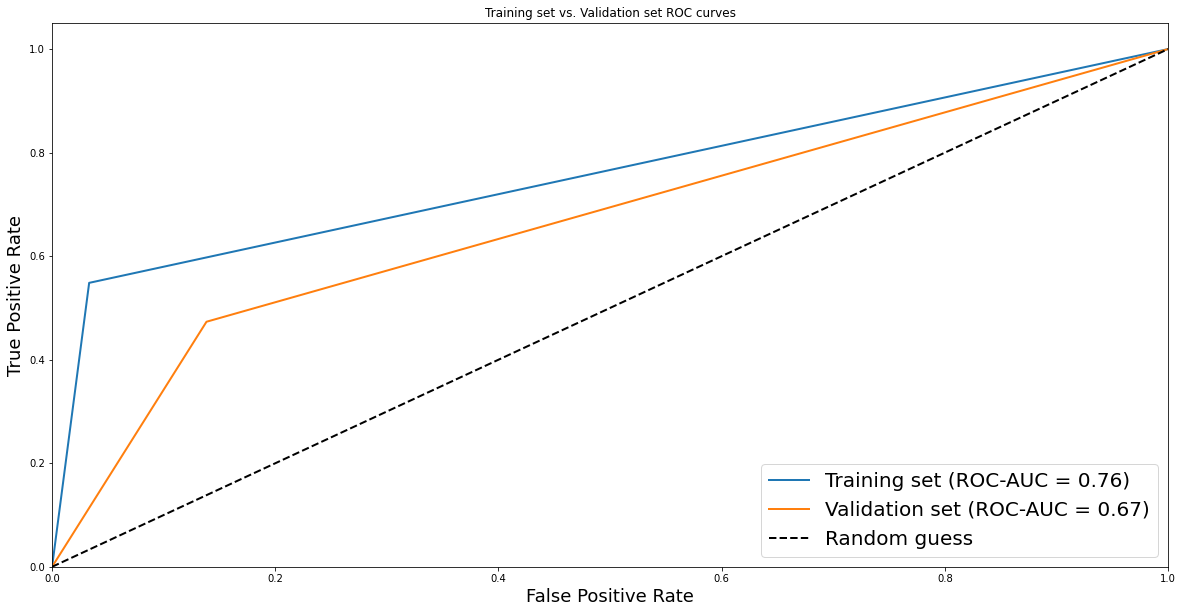

In [74]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
# pred = [model.predict(train_features_flat), model.predict(val_features_flat)]
pred = [train_y_hat.argmax(axis=1), val_y_hat.argmax(axis=1)]
actual = [train_y.argmax(axis=1), val_y.argmax(axis=1)]
stats(pred, actual)

# Akiva

In [58]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

 #given some input tensor(s) and output tensor(s)
 #This model will include all layers required in the computation

x  = vgg16.get_layer('fc2').output

# I use a 2 unit dense layer in the end with softmax activation as I have 4 
# classes to predict from in the end
prediction = Dense(2, activation='softmax', name='predictions')(x)

model_ak = Model(inputs=vgg16.input, outputs=prediction)




# Adam optimiser to reach to the global minima while training out model. 
# If I am stuck in local minima while training then the adam optimiser will 
# help us to get out of local minima and reach global minima.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

TypeError: ignored

In [ ]:
for layer in model_ak.layers:
    layer.trainable = False

for layer in model_ak.layers[-20:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name) 

opt = Adam(lr=0.000001)
model_ak.compile(optimizer=opt, loss=binary_crossentropy, 
              metrics=['accuracy', 'mae'])
model_ak.summary()

In [ ]:
#  Save the model by monitoring a specific parameter of the model. In this case I am monitoring 
#  validation accuracy by passing val_acc to ModelCheckpoint
checkpoint = ModelCheckpoint("vgg16_base_res.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')

#  monitoring validation accuracy by passing val_acc to EarlyStopping. set patience 
#  to 20 which means that the model will stop to train if it doesn’t see any rise
# in validation accuracy in 20 epochs.
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
print(max_val)
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

In [ ]:
hist = model.fit(train_x, steps_per_epoch=train_x.samples//train_x.batch_size, validation_data=val_x, 
                 class_weight=class_weights, validation_steps=val_x.samples//val_x.batch_size, 
                 epochs=110,callbacks=[checkpoint,early])

# Fitting a  k -NN Classifier

In [21]:
train_y = train_y.astype(int)
val_y= val_y.astype(int)

In [42]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=19)
# print(train_y[:2])

#Train the model using the training sets
knn.fit(train_features_flat, train_y)


#Predict the response for test dataset
y_pred = knn.predict(val_features_flat)
print(y_pred.shape)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))


(309, 2)
Accuracy: 0.7313915857605178


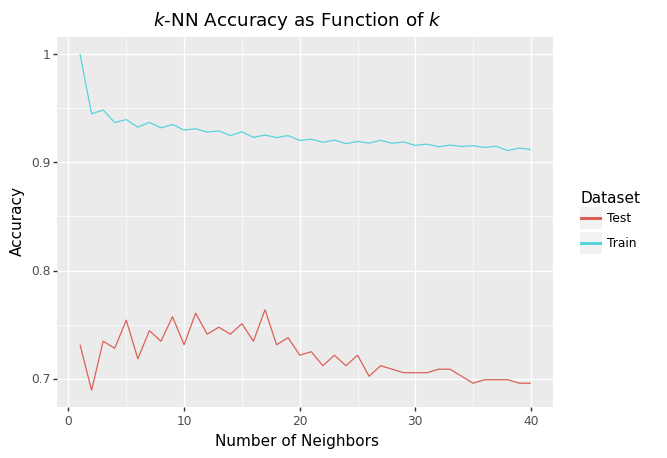

<ggplot: (8747474093341)>

In [64]:
ks = range(1, 41)
train, test = [], []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_features_flat, train_y)
    train.append(knn.score(train_features_flat, train_y))
    test.append(knn.score(val_features_flat, val_y))

from plotnine import *
p = (ggplot(pd.melt(pd.DataFrame({"k": ks, "Train": train, "Test": test}), id_vars="k"), 
       aes(x="k", y="value", color="variable")) + 
 geom_line() + 
 labs(x="Number of Neighbors", y="Accuracy", color="Dataset", title=r"$k$-NN Accuracy as Function of $k$"))
p

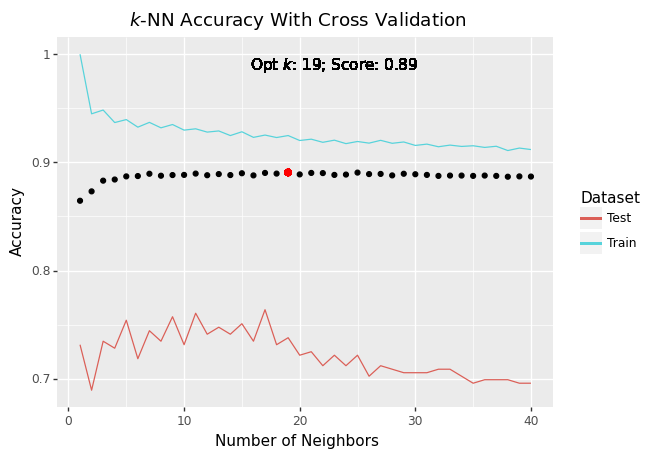

<ggplot: (8747462524385)>

In [65]:
from sklearn.model_selection import GridSearchCV

# Specifying values to scan. Dictionary keys correspond to arguments passed to model's constructor.
param_grid = {'n_neighbors':ks}

# Perform the Cross-Validation (with 5 folds) over all combinations of parameter values specified in dictionary
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5).fit(train_features_flat, train_y)

opt_k = knn_cv.best_params_["n_neighbors"]
opt_score = knn_cv.best_score_

(p + geom_point(data=pd.DataFrame({"k": ks ,"cv": knn_cv.cv_results_["mean_test_score"]}), 
               mapping=aes(x="k", y="cv"), color="black") + 
 geom_point(aes(x=opt_k, y=opt_score), color="Red", size=2) + 
 geom_text(label=r"Opt $k$: %d; Score: %.2f" % (opt_k, round(opt_score, 2)), x=opt_k + 4, y= opt_score + .1, color="black") +
 labs(title=r"$k$-NN Accuracy With Cross Validation"))

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=19).fit(train_features_flat, train_y)
print("Train accuracy: %.2f.\nTest accuracy: %.2f" % ( knn.score(train_features_flat, train_y), knn.score(val_features_flat, val_y) ))

Train accuracy: 0.93.
Test accuracy: 0.73


In [45]:
cm = metrics.confusion_matrix(val_y, y_pred)
print("KNN Classifier confusion matrix: ",cm)

KNN Classifier confusion matrix:  [[147  12]
 [ 64  86]]


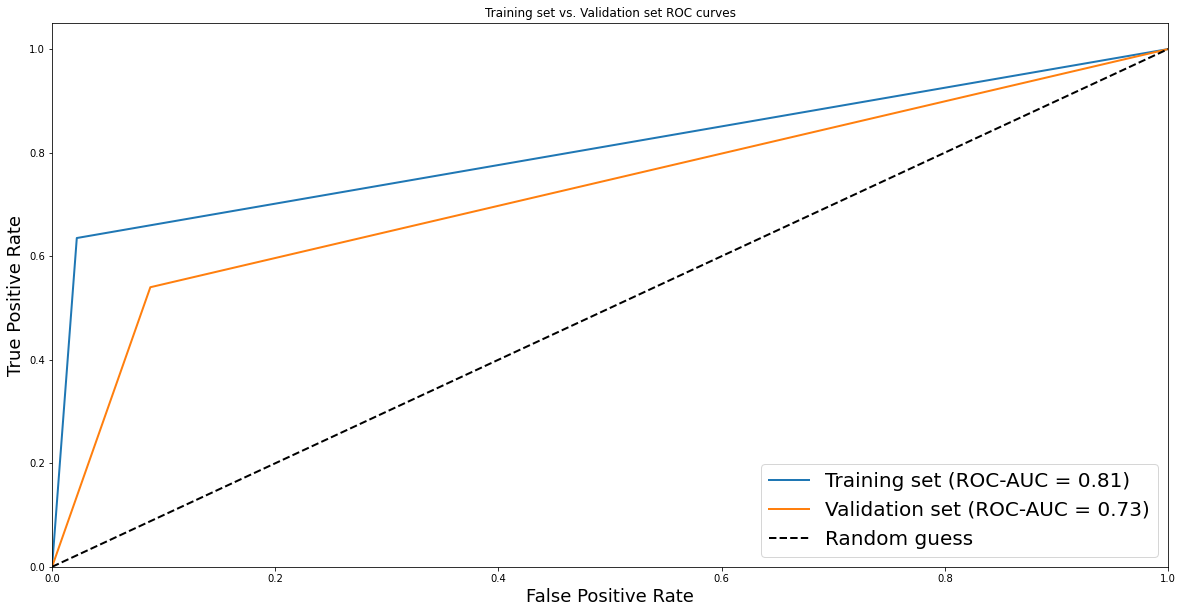

In [24]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [knn.predict(train_features_flat), knn.predict(val_features_flat)]
actual = [train_y, val_y]
stats(pred, actual)

# Fitting a DecisionTree Classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(train_features_flat, train_y)
train_y_pred_clf = clf.predict(train_features_flat)
print("Train Accuracy:",metrics.accuracy_score(train_y, train_y_pred_clf))
y_pred_clf = clf.predict(val_features_flat)
print("Validation Accuracy:",metrics.accuracy_score(val_y, y_pred_clf))

NameError: ignored

In [58]:
cm_clf = metrics.confusion_matrix(val_y, y_pred_clf)
print("DT Classifier confusion matrix: ",cm_clf)

DT Classifier confusion matrix:  [[141  18]
 [ 73  77]]


In [32]:
from sklearn.tree import DecisionTreeClassifier

clf =DecisionTreeClassifier(max_depth=7).fit(train_features_flat, train_y)
print("Train accuracy: %.2f.\nTest accuracy: %.2f" % ( clf.score(train_features_flat, train_y), knn.score(val_features_flat, val_y) ))

Train accuracy: 0.94.
Test accuracy: 0.73


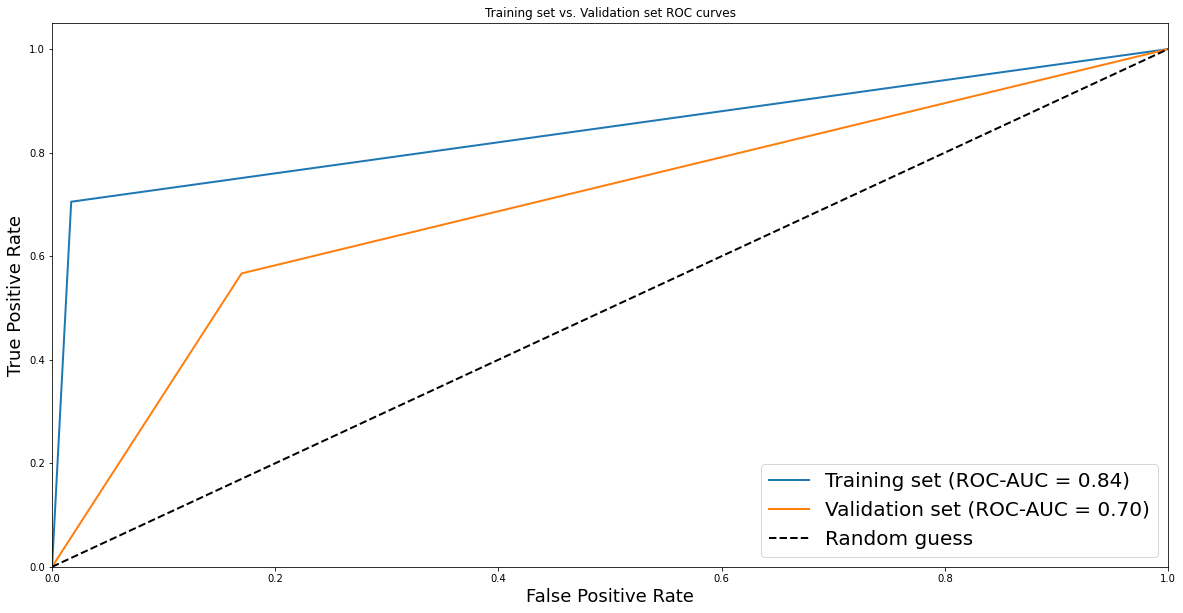

In [33]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [clf.predict(train_features_flat), clf.predict(val_features_flat)]
actual = [train_y, val_y]
stats(pred, actual)

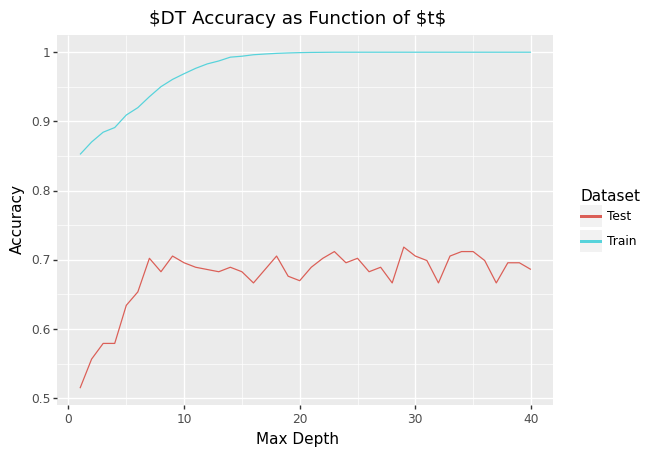

<ggplot: (8747462398065)>

In [69]:
from sklearn.model_selection import GridSearchCV

ts = range(1, 41)
train, test = [], []
for t in ts:
    dt = DecisionTreeClassifier(max_depth=t).fit(train_features_flat, train_y)
    train.append(dt.score(train_features_flat, train_y))
    test.append(dt.score(val_features_flat, val_y))

from plotnine import *
p = (ggplot(pd.melt(pd.DataFrame({"t": ts, "Train": train, "Test": test}), id_vars="t"), 
       aes(x="t", y="value", color="variable")) + 
 geom_line() + 
 labs(x="Max Depth", y="Accuracy", color="Dataset", title=r"$DT Accuracy as Function of $t$"))
p


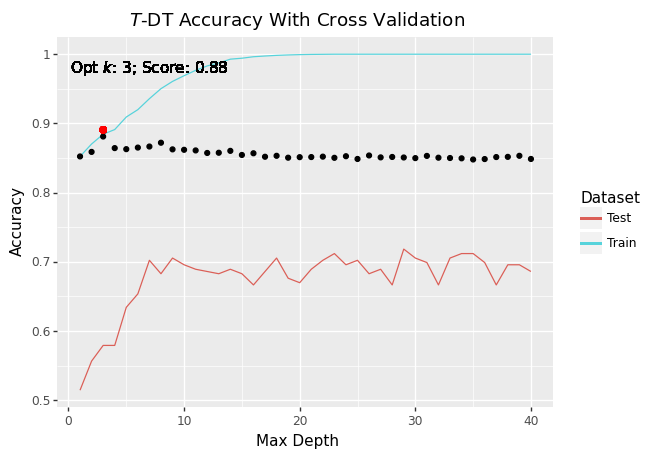

<ggplot: (8747481242060)>

In [75]:
# Specifying values to scan. Dictionary keys correspond to arguments passed to model's constructor.
param_grid_t = {'max_depth':ts}

# Perform the Cross-Validation (with 5 folds) over all combinations of parameter values specified in dictionary
dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid_t, cv=5).fit(train_features_flat, train_y)

opt_t = dt_cv.best_params_["max_depth"]
opt_score_t = dt_cv.best_score_

(p + geom_point(data=pd.DataFrame({"t": ts ,"cv": dt_cv.cv_results_["mean_test_score"]}), 
               mapping=aes(x="t", y="cv"), color="black") + 
 geom_point(aes(x=opt_t, y=opt_score), color="Red", size=2) + 
 geom_text(label=r"Opt $k$: %d; Score: %.2f" % (opt_t, round(opt_score_t, 2)), x=opt_t + 4, y= opt_score_t + .1, color="black") +
 labs(title=r"$T$-DT Accuracy With Cross Validation"))

# ℓ1,ℓ2  Regularization for Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(solver="saga", tol=1e-4, max_iter=1e4).fit(train_features_flat, train_y)
print("Train accuracy: %.2f.\nTest accuracy: %.2f" % ( lg.score(train_features_flat, train_y), lg.score(val_features_flat, val_y) ))

Train accuracy: 0.91.
Test accuracy: 0.69


In [ ]:
def plot_model_performance(penalty, Cs, trainX, trainY, testX, testY):
    """
    Given a penalty (regularization) type and a collection of C values to check, fit a penalized logistic regression 
    model for each over given training data. Then record scores over train and test in fitting arrays.
    :param penalty: Regularization type ("l1", "l2") 
    :param Cs: C values to check
    :param trainX: Design matrix to fit a model for
    :param trainY: Response vector to fit a model for
    :param testX: Design matrix to test model over
    :param testY: Response vector to test model over
    :return: A ggplot showing train and test scores of each fitted regularized model
    
    Hint: You already saw a graph like this earlier :)
    """
    train, test = [], []
    for c in Cs:
        # Fit a Logistic regression model and append train and test scores to lists. 
        lg = LogisticRegression(penalty , C=c , solver="saga", tol=1e-4, max_iter=1e4).fit(trainX, trainY)
        score_train,  score_test = lg.score(trainX, trainY), lg.score(testX, testY)
        train.append(score_train)
        test.append(score_test)
        # Set: `solver="sage"`, tol and max_iter as above. 
        # Do not forget to pass penalty type and C value.

    p = (ggplot(pd.melt(pd.DataFrame({"C": np.log(Cs), "Train": train, "Test": test}), id_vars="C"), 
       aes(x="C", y="value", color="variable")) + 
          geom_line() + 
          labs(x=" C values", y="Accuracy", color="Dataset", title=r"Logistic regression Accuracy as Function of $C$"))


    # Return a ggplot over score as a function of np.log(Cs). Include penalty type in plot's title
    return p




In [ ]:
Cs = 2**np.linspace(-11,.5, 50)
l1_p = plot_model_performance("l1", Cs, train_features_flat, train_y, val_features_flat, val_y)


In [ ]:
l2_p = plot_model_performance("l2", Cs, train_features_flat, train_y, val_features_flat, val_y)

[l1_p, l2_p]

# SVM Classifier using pca for feature reduction

In [34]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [36]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 225
h, w = 126,32

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, train_features_flat.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(train_features_flat)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(train_features_flat)
X_test_pca = pca.transform(val_features_flat)
print("done in %0.3fs" % (time() - t0))


Extracting the top 225 eigenfaces from 6568 faces
done in 1.315s


ValueError: ignored

In [ ]:
# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 30, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 6, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               737408    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4

In [19]:
# Model fit
history = model.fit(train_x, train_y, batch_size = batch_size, epochs = no_epochs, 
                    validation_data = (val_x, val_y))

Epoch 1/10
411/411 [==============================] - 2s 6ms/step - loss: 0.4956 - auc: 0.9303 - accuracy: 0.9039 - val_loss: 0.5885 - val_auc: 0.8116 - val_accuracy: 0.7476
Epoch 2/10
411/411 [==============================] - 2s 5ms/step - loss: 0.2341 - auc: 0.9518 - accuracy: 0.9222 - val_loss: 0.5351 - val_auc: 0.8668 - val_accuracy: 0.7540
Epoch 3/10
411/411 [==============================] - 2s 5ms/step - loss: 0.2053 - auc: 0.9626 - accuracy: 0.9339 - val_loss: 0.4554 - val_auc: 0.8998 - val_accuracy: 0.8220
Epoch 4/10
411/411 [==============================] - 2s 5ms/step - loss: 0.1823 - auc: 0.9705 - accuracy: 0.9412 - val_loss: 0.5214 - val_auc: 0.9031 - val_accuracy: 0.7994
Epoch 5/10
411/411 [==============================] - 2s 5ms/step - loss: 0.1684 - auc: 0.9756 - accuracy: 0.9460 - val_loss: 0.4233 - val_auc: 0.9118 - val_accuracy: 0.8220
Epoch 6/10
411/411 [==============================] - 2s 5ms/step - loss: 0.1603 - auc: 0.9764 - accuracy: 0.9490 - val_loss: 0.44

#### **Results**
Submissions are evaluated on the area under the Receiver Operating Characteristic Curve ([ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))   
on the predicted probabilities, as calculated by [roc_auc_score in scikit-learn (v 0.23.1)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).


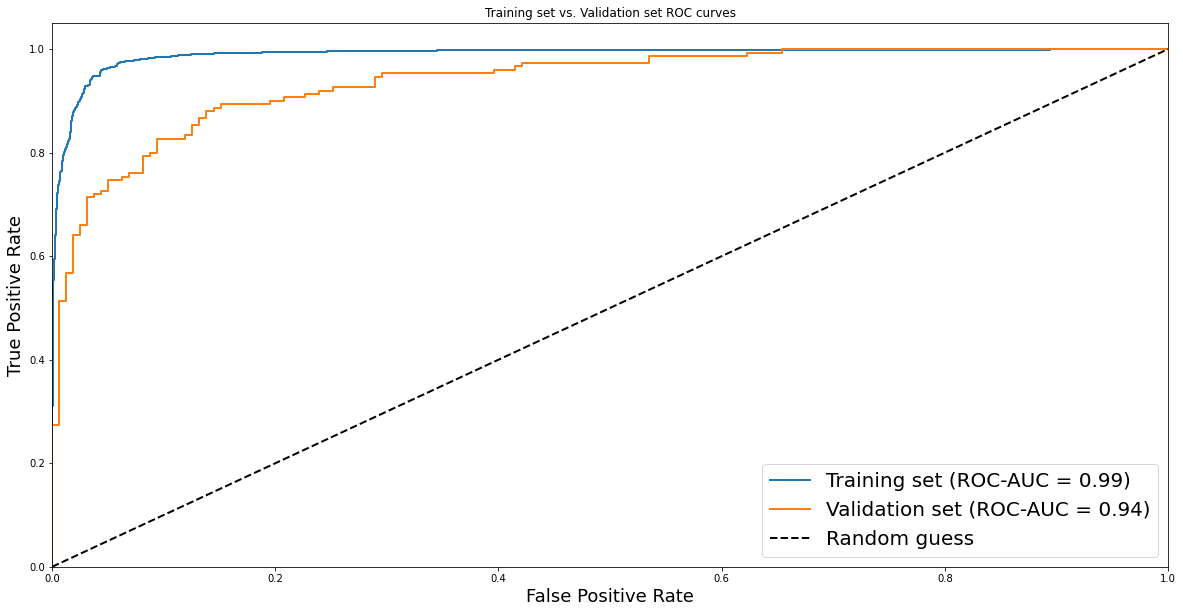

In [20]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [model.predict(train_x), model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)

## **Final Submission File**

Create a CSV submission file , zip and download it.

In [ ]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

In [ ]:
# Download zip file
from zipfile import ZipFile
from google.colab import files

with ZipFile('submission.zip', 'w') as myzip:
  myzip.write('submission.csv')

files.download('submission.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>